# 1. Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from pyod.models.iforest import IForest
from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import tensorflow as tf

import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings(action='ignore')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
import os
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10643463733610517597
xla_global_id: -1
]
[]


In [25]:
path = "./Dataset/"

# original data -> original
original = pd.read_csv(path+"train_A.csv")  
original

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,X_132,X_133,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,1,0.532754,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.517402,T050307,A_31,NaN,NaN,20153.0,24984.0,0.21,0.22,...,53.55,52.68,49.97,56.66,63.52,1.0,210.5,214.6,201.6,191.9
2,0,0.522159,T050304,A_31,18031.0,18031.0,NaN,NaN,0.19,0.20,...,57.74,52.51,54.45,57.99,63.16,1.0,NaN,NaN,NaN,NaN
3,2,0.541429,T050304,A_31,8164.0,8164.0,NaN,NaN,0.19,0.20,...,56.38,57.10,51.49,56.08,64.40,1.0,NaN,NaN,NaN,NaN
4,1,0.526517,T050307,A_31,NaN,NaN,17014.0,21844.0,0.20,0.22,...,50.45,50.29,57.54,52.59,62.37,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2,0.548592,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290,1,0.526997,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,1,0.530940,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,0,0.516681,T050304,A_31,10729.0,10729.0,NaN,NaN,0.20,0.21,...,51.30,47.66,60.00,53.75,62.58,1.0,NaN,NaN,NaN,NaN


In [7]:
dataset = []

t50304 = original[original['LINE'] =='T050304']
t50307 = original[original['LINE'] =='T050307']
t503 = pd.concat([t50304, t50307]).reset_index(drop=True)
dataset.append(t503)

t10305 = original[original['LINE'] =='T010305']
t10306 = original[original['LINE'] =='T010306']
t103 = pd.concat([t10305, t10306]).reset_index(drop=True)
dataset.append(t103)

dataset[0]

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,X_132,X_133,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,0,0.522159,T050304,A_31,18031.0,18031.0,NaN,NaN,0.19,0.20,...,57.74,52.51,54.45,57.99,63.16,1.0,NaN,NaN,NaN,NaN
1,2,0.541429,T050304,A_31,8164.0,8164.0,NaN,NaN,0.19,0.20,...,56.38,57.10,51.49,56.08,64.40,1.0,NaN,NaN,NaN,NaN
2,1,0.529130,T050304,A_31,21863.0,21863.0,NaN,NaN,0.20,0.21,...,58.07,55.23,51.33,56.78,63.48,1.0,NaN,NaN,NaN,NaN
3,1,0.528817,T050304,A_31,19078.0,19078.0,NaN,NaN,0.20,0.21,...,56.66,60.49,40.51,48.65,63.70,1.0,NaN,NaN,NaN,NaN
4,1,0.526868,T050304,A_31,22322.0,22322.0,NaN,NaN,0.20,0.21,...,55.91,56.14,40.27,56.86,61.74,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0,0.521494,T050307,A_31,NaN,NaN,896.0,896.0,0.19,0.21,...,55.25,51.05,49.83,58.79,63.26,1.0,NaN,NaN,NaN,NaN
148,2,0.540724,T050307,A_31,NaN,NaN,17860.0,17860.0,0.19,0.20,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
149,2,0.541819,T050307,A_31,NaN,NaN,19854.0,19854.0,0.20,0.21,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
150,2,0.552100,T050307,A_31,NaN,NaN,17771.0,17771.0,0.19,0.20,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


# 2. Preprocessing

1. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1) 
2. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제 
3. 결측치 처리 (KNN Imputetor, fillna(0))
4. 정규화 (Robust, MinMax, Standard)
5. 카테고리 변수 수치화 (LINE, PRODUCT_CODE) LabelEncoder

In [180]:
# 1. Handling missing values  
# Preprocessed data -> processed_dataset
processed_dataset = []

for data in dataset: 
    data = data.drop(['Y_Class'], axis=1)
    data = data.fillna(0)
    processed_dataset.append(data)

In [181]:
# 2. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1)
for i, data in enumerate(processed_dataset):
    # Get the counts of unique values per column
    value_counts = data.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))

    # Filter columns with only one unique value
    unique_columns = value_counts[value_counts >= 2].index
    duplicated_columns = value_counts[value_counts <= 1].index

    data = data.drop(duplicated_columns, axis=1)
    processed_dataset[i] =  data

In [182]:
# 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
for i, data in enumerate(processed_dataset):
    df = data.iloc[:,4:].T.drop_duplicates(keep='first').T
    data = pd.concat([data.iloc[:,:4], df], axis=1)
    processed_dataset[i] = data

In [183]:
# 4. Regularization -> robust scaler
rs = RobustScaler()
ss = StandardScaler()

for i, data in enumerate(processed_dataset):
    data.iloc[:, 4:] = rs.fit_transform(data.iloc[:, 4:])
    processed_dataset[i] = data

In [184]:
# 5. Label Encoding 
le = LabelEncoder() 
le.fit(original['LINE'])
print(le.classes_)

for i, data in enumerate(processed_dataset):
    data['LINE'] = le.transform(data['LINE'])
    data['PRODUCT_CODE'] = data['PRODUCT_CODE'].replace({'A_31': 0})
    processed_dataset[i] = data

['T010305' 'T010306' 'T050304' 'T050307']


In [111]:
# # 6. Multicollinearity 
# from collinearity import SelectNonCollinear

# for i, data in enumerate(processed_dataset):
#     nonX_data = data.iloc[:, :3]
#     X_data = data.iloc[:, 3:]
    
#     selector = SelectNonCollinear(0.9)
#     selector.fit(X_data.values)
#     mask = selector.get_support() # True or False

#     selected_df = pd.DataFrame(X_data.loc[:,mask])
#     data = pd.concat([nonX_data, selected_df], axis=1)
#     processed_dataset[i] =  data

# 3. Data Split

In [220]:
# Copy processed data for input data 
input_data = processed_dataset[1].copy()

# 4. Modeling 


In [221]:
from pycaret.regression import *
from time import time

# Setup Environment  
cat_cols = ['LINE', 'PRODUCT_CODE', 'Y_Class']
FOLD = 5

reg = setup(data = input_data, 
            train_size = 0.8,
            target = 'Y_Quality',
            ignore_features = cat_cols,
#            preprocess = True,  # default True
            remove_multicollinearity = True,
            multicollinearity_threshold = 0.9,
            feature_selection = True,
            n_features_to_select = 0.1, 
            fold=FOLD, # defualt 10 
            fold_shuffle=True,
            use_gpu = True,
            session_id = SEED)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,42
1,Target,Y_Quality
2,Target type,Regression
3,Original data shape,"(142, 597)"
4,Transformed data shape,"(142, 60)"
5,Transformed train set shape,"(113, 60)"
6,Transformed test set shape,"(29, 60)"
7,Ignore features,3
8,Numeric features,594
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [222]:
# EG, Cat, GBR, LGBM, XGB
top5 = compare_models(sort='r2', n_select=5, fold=FOLD, exclude=['lar', 'par', 'huber'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0038,0.0000,0.0051,0.7076,0.0033,0.0071,0.4920
ada,AdaBoost Regressor,0.0040,0.0000,0.0053,0.6877,0.0034,0.0075,0.4480
rf,Random Forest Regressor,0.0040,0.0000,0.0054,0.6706,0.0035,0.0074,0.5300
gbr,Gradient Boosting Regressor,0.0039,0.0000,0.0054,0.6592,0.0035,0.0073,0.5160
xgboost,Extreme Gradient Boosting,0.0040,0.0000,0.0055,0.6202,0.0036,0.0075,0.6580
catboost,CatBoost Regressor,0.0041,0.0000,0.0058,0.6126,0.0038,0.0077,11.1040
omp,Orthogonal Matching Pursuit,0.0053,0.0000,0.0065,0.4991,0.0042,0.0099,0.3940
dt,Decision Tree Regressor,0.0050,0.0000,0.0067,0.4617,0.0044,0.0095,0.3780
lightgbm,Light Gradient Boosting Machine,0.0052,0.0001,0.0070,0.4428,0.0046,0.0098,0.5660
br,Bayesian Ridge,0.0059,0.0001,0.0075,0.2864,0.0049,0.0111,0.3780


In [223]:
total_models = []
tuned_models = []

for i, model in enumerate(top5):
    cell_start_time = time() 
    print(top5[i])
    model = create_model(model, fold=FOLD)
#    tuned_model = tune_model(model, fold=5, optimize='r2', choose_better=True)
    total_models.append(model)
#    tuned_models.append(tuned_model)
    cell_end_time = time()
    print("CELL RUN TIME: ", cell_end_time - cell_start_time)

ExtraTreesRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0027,0.0000,0.0035,0.7999,0.0023,0.0051
1,0.0043,0.0000,0.0053,0.7062,0.0035,0.0081
2,0.0041,0.0000,0.0052,0.6204,0.0034,0.0076
3,0.0033,0.0000,0.0046,0.7124,0.0030,0.0062
4,0.0045,0.0000,0.0068,0.6990,0.0045,0.0086
Mean,0.0038,0.0000,0.0051,0.7076,0.0033,0.0071
Std,0.0007,0.0000,0.0011,0.0570,0.0007,0.0013


CELL RUN TIME:  3.2159080505371094
AdaBoostRegressor(random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0028,0.0000,0.0039,0.7492,0.0025,0.0052
1,0.0040,0.0000,0.0048,0.7629,0.0031,0.0075
2,0.0041,0.0000,0.0052,0.6226,0.0034,0.0076
3,0.0040,0.0000,0.0051,0.6551,0.0033,0.0075
4,0.0051,0.0001,0.0074,0.6487,0.0048,0.0098
Mean,0.0040,0.0000,0.0053,0.6877,0.0034,0.0075
Std,0.0007,0.0000,0.0012,0.0570,0.0008,0.0015


CELL RUN TIME:  2.994816541671753
RandomForestRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0028,0.0000,0.0037,0.7749,0.0024,0.0052
1,0.0041,0.0000,0.0053,0.7123,0.0034,0.0076
2,0.0046,0.0000,0.0061,0.4796,0.0040,0.0086
3,0.0034,0.0000,0.0045,0.7277,0.0029,0.0064
4,0.0049,0.0001,0.0073,0.6587,0.0048,0.0093
Mean,0.0040,0.0000,0.0054,0.6706,0.0035,0.0074
Std,0.0008,0.0000,0.0013,0.1025,0.0008,0.0015


CELL RUN TIME:  3.4060003757476807
GradientBoostingRegressor(random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0027,0.0000,0.0037,0.7727,0.0024,0.0052
1,0.0043,0.0000,0.0054,0.6956,0.0035,0.0080
2,0.0048,0.0000,0.0069,0.3507,0.0045,0.0090
3,0.0031,0.0000,0.0042,0.7622,0.0027,0.0058
4,0.0046,0.0000,0.0067,0.7146,0.0044,0.0087
Mean,0.0039,0.0000,0.0054,0.6592,0.0035,0.0073
Std,0.0008,0.0000,0.0013,0.1569,0.0008,0.0016


CELL RUN TIME:  3.3415117263793945
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0034,0.0000,0.0041,0.7185,0.0027,0.0063
1,0.0037,0.0000,0.0046,0.7844,0.0030,0.0069
2,0.0056,0.0001,0.0081,0.1014,0.0052,0.0105
3,0.0032,0.0000,0.0042,0.7661,0.0027,0.0060
4,0.0042,0.0000,0.0065,0.7306,0.0042,0.0080
Mean,0.0040,0.0000,0.0055,0.6202,0.0036,0.0075
Std,0.0009,0.0000,0.0016,0.2605,0.0010,0.0016


CELL RUN TIME:  3.8786051273345947


In [224]:
blender_top5 = blend_models(estimator_list=total_models)
#blender_tuned5 = blend_models(estimator_list=tuned_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0027,0.0000,0.0035,0.7905,0.0023,0.0051
1,0.0039,0.0000,0.0048,0.7613,0.0031,0.0072
2,0.0042,0.0000,0.0057,0.5447,0.0037,0.0079
3,0.0031,0.0000,0.0043,0.7559,0.0028,0.0058
4,0.0046,0.0000,0.0068,0.7002,0.0045,0.0087
Mean,0.0037,0.0000,0.0050,0.7105,0.0033,0.0069
Std,0.0007,0.0000,0.0011,0.0879,0.0008,0.0013


In [225]:
# for naive models 
total_predictions = []
for model in total_models: 
    pred = predict_model(model)
    total_predictions.append(pred)
print() 

#for tuned models 
# for model in tuned_models: 
#     prediction = predict_model(model)
# print() 

# for blended model 
pred_blend_top5 = predict_model(blender_top5)
print() 

# for blended model (tuned)
# pred_blend_tuned5 = predict_model(blender_tuned5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0036,0.0000,0.0047,0.5964,0.0031,0.0068


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.0039,0.0000,0.0049,0.5686,0.0032,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0040,0.0000,0.0051,0.5273,0.0034,0.0076


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.0038,0.0000,0.0047,0.6082,0.0031,0.0072


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.0041,0.0000,0.0051,0.5361,0.0033,0.0077


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0037,0.0000,0.0047,0.5973,0.0031,0.0070


In [226]:
CHECK = 3

In [227]:
evaluate_model(total_models[CHECK])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

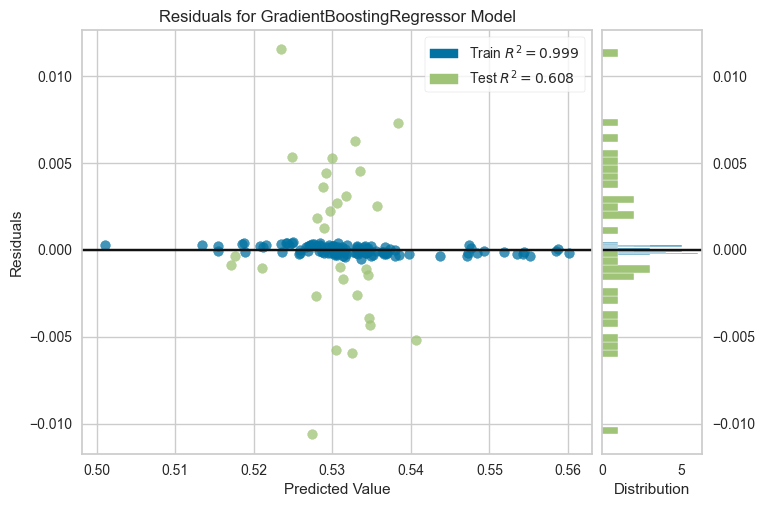

In [228]:
plot_model(total_models[CHECK], plot='residuals')
# plot_model(blender_top5, plot='residuals')

In [218]:
interpret_model(total_models[CHECK], plot='summary')

TypeError: This function only supports tree based models for binary classification: catboost, dt, lightgbm, et, xgboost, rf.

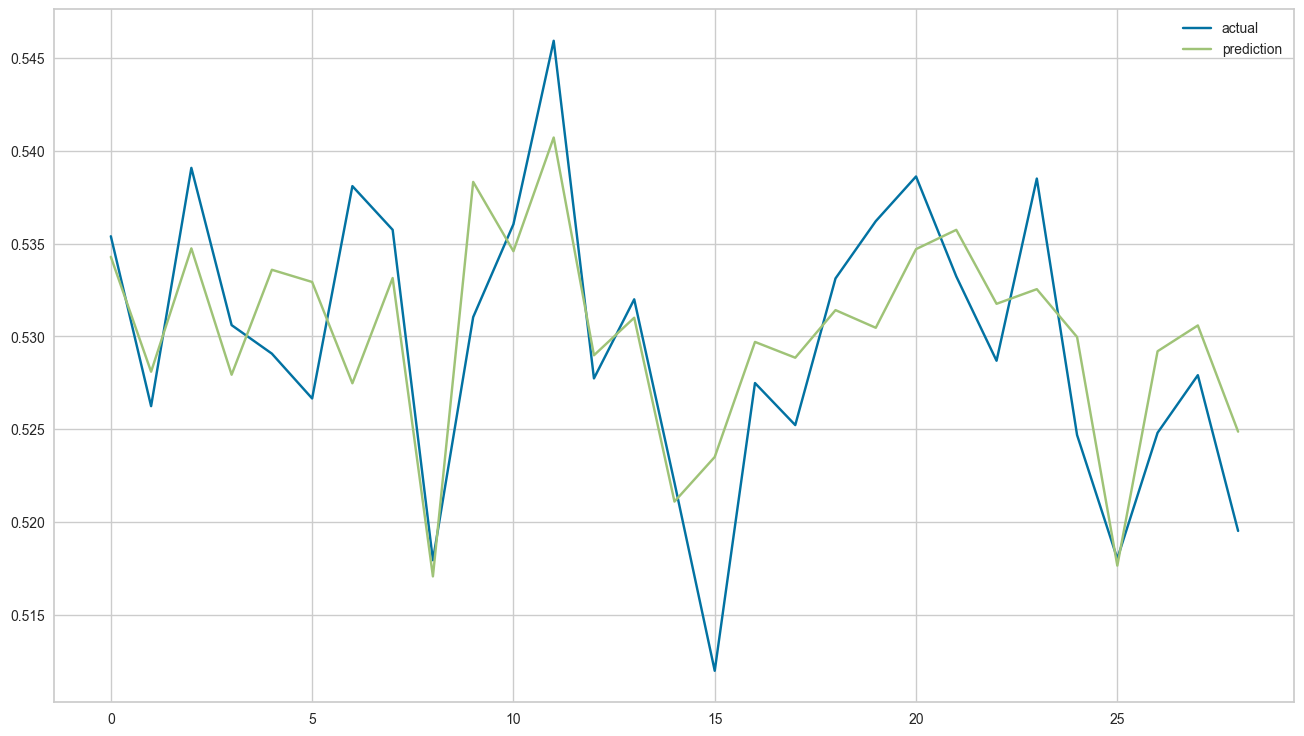

In [229]:
def graph(pred, true) :
    plt.figure(figsize=(16, 9))
    plt.plot(true, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

true_y = total_predictions[CHECK]['Y_Quality'].to_numpy() # total_predictions[CHECK]
pred_y = total_predictions[CHECK]['prediction_label'].to_numpy()
graph(pred_y, true_y)